# Experimento 2: Lag

Aqui experimentamos como cambia la simulación al variar el tiempo que tienen que esperar los paises para desarrollar sus productos.
Recordemos que el tiempo de espera por producto es $ \left \lceil \Delta * \text{PCI} + 1 \right \rceil$, donde $\text{PCI}$ es la complejidad del producto normalizada entre 0 y 1.

El valor de la variable $\Delta$ representa la cota máxima de espera para los productos. Es decir, el producto más complejo cuya complejidad tenga un $\text{PCI} = 1$ llevará $\Delta$ iteraciones para desarrollarse. Esto naturalmente implica que la simulación requiere más iteraciones para converger.

In [1]:
from lib.data import *
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps
import economic_complexity as ecplx
#from informe import SimuladorEstatico, SimuladorDinamico, SimuladorComplejo, PaisNaive
from informe import *
from lib.utils import correr_simulacion_mostrando, cantidad_descubrimientos_iteracion
import numpy as np

data, raw = get_default_oec_rca_raw_data()

Se cargaron los datos desde ../data/default_oce_2018-2020.pkl


In [2]:
rca = ecplx.rca(data)
M = build_M_from(rca)

In [3]:
lags = [1, 5, 10, 20, 50, 100]
iteraciones = [ 100, 100, 100, 150, 300, 600 ]

historias_cigarras = []
historias_hormigas = []
for lag, it in zip( lags, iteraciones):
    cigarras = SimuladorComplejo(lambda step: step > it , PaisCigarra, M.copy(deep=True), 0.55, lag)
    hormigas = SimuladorComplejo(lambda step: step > it , PaisHormiga, M.copy(deep=True), 0.55, lag)

    historias_cigarras.append( correr_simulacion_mostrando(cigarras, False) )
    historias_hormigas.append( correr_simulacion_mostrando(hormigas, False) )

proximidad calculada en: 0.17146992683410645
paises creados en: 0.01467585563659668
proximidad calculada en: 0.1699051856994629
paises creados en: 0.014588594436645508
empezando simulación: 2024-10-23 21:06:05
empezando simulación: 2024-10-23 21:07:12
proximidad calculada en: 0.18228602409362793
paises creados en: 0.01403355598449707
proximidad calculada en: 0.1653900146484375
paises creados en: 0.014270782470703125
empezando simulación: 2024-10-23 21:08:20
empezando simulación: 2024-10-23 21:09:25
proximidad calculada en: 0.1884136199951172
paises creados en: 0.01477503776550293
proximidad calculada en: 0.18196892738342285
paises creados en: 0.013890504837036133
empezando simulación: 2024-10-23 21:10:33
empezando simulación: 2024-10-23 21:11:38
proximidad calculada en: 0.1739187240600586
paises creados en: 0.013464689254760742
proximidad calculada en: 0.171370267868042
paises creados en: 0.014369010925292969
empezando simulación: 2024-10-23 21:12:47
empezando simulación: 2024-10-23 21

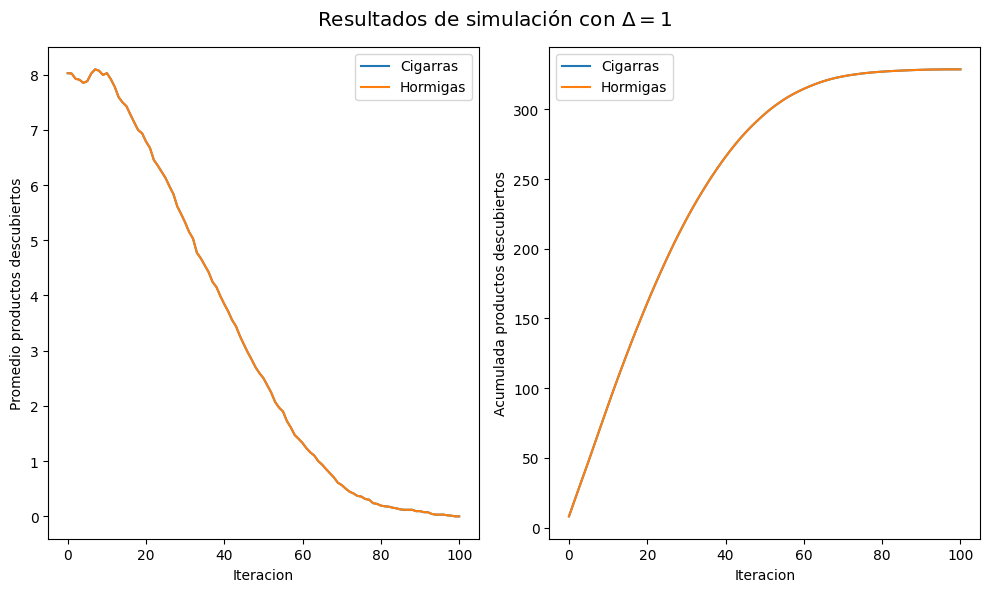

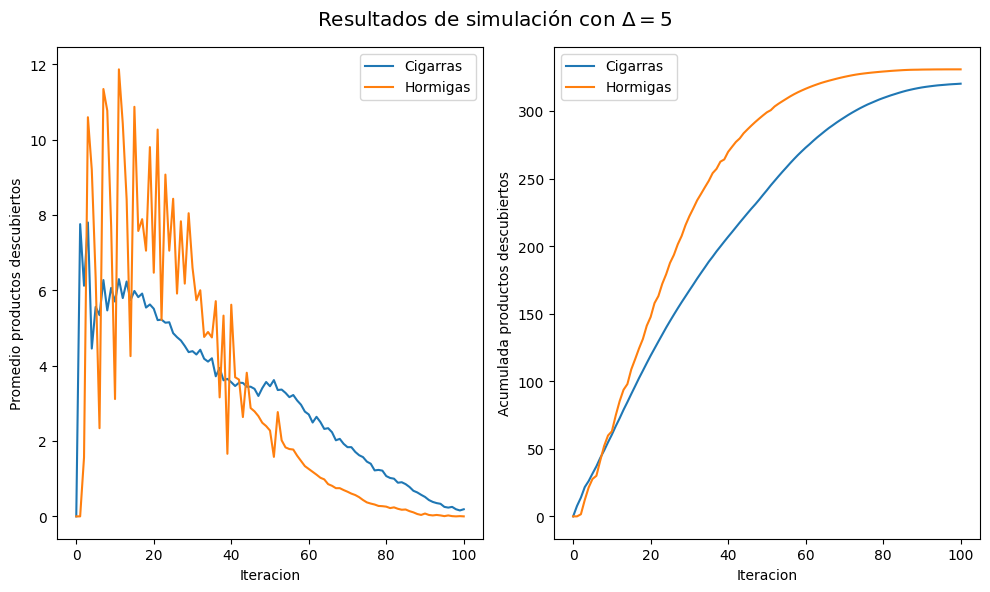

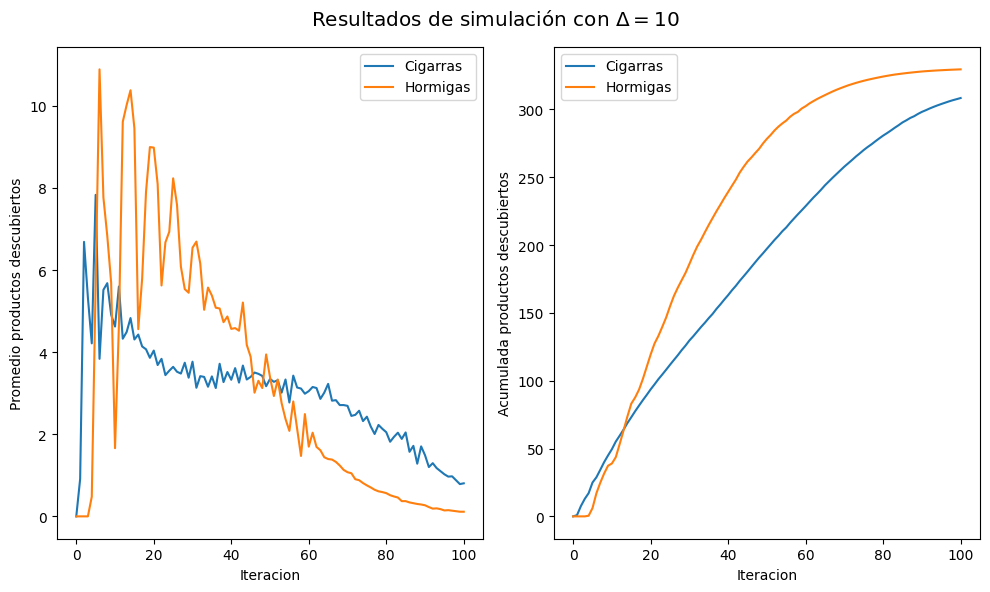

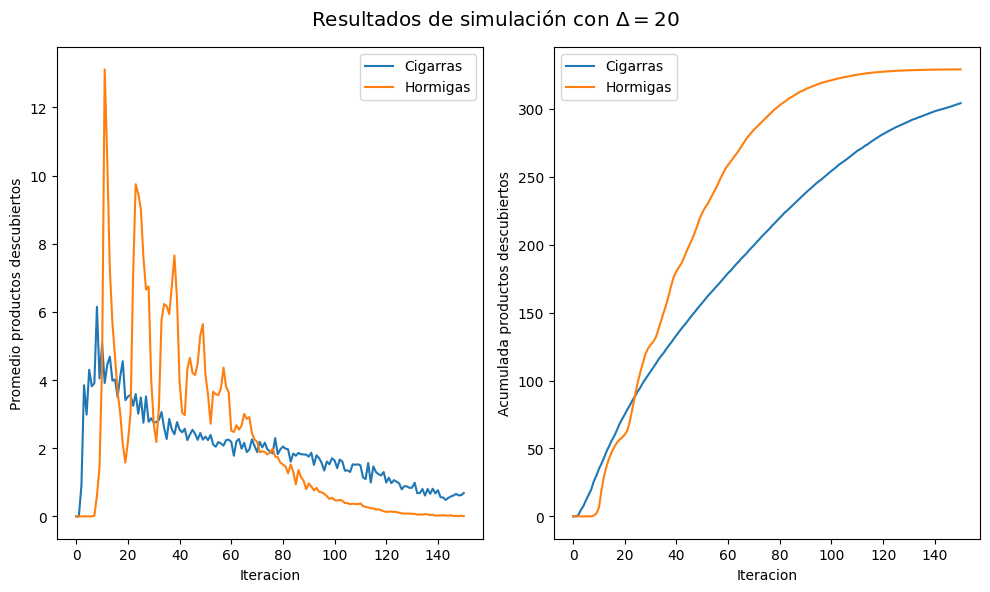

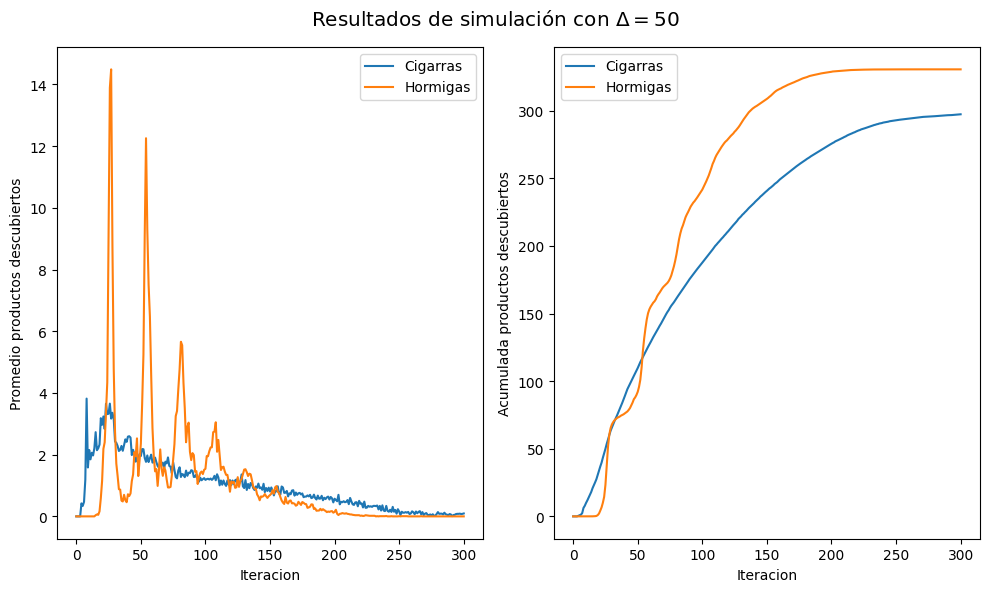

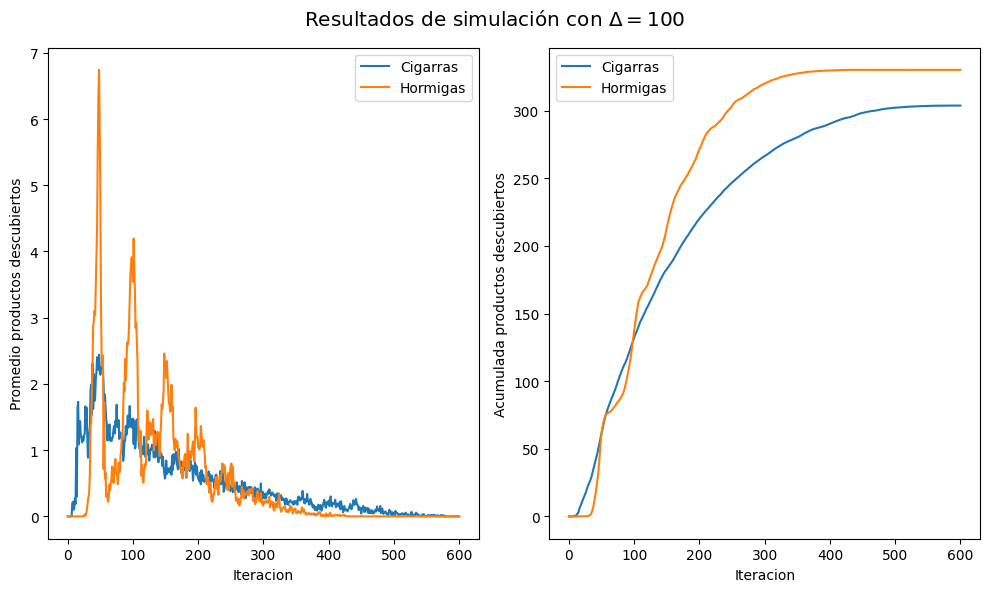

In [4]:
cant_paises = len(M.index.to_list())

for lag, historia_cigarra, historia_hormiga in zip(lags, historias_cigarras, historias_hormigas):
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(r"Resultados de simulación con $\Delta = %s $" %(str(lag)) , fontsize="x-large")

    plt.subplot(1,2,1)
    plt.plot(range(len(historia_cigarra)), cantidad_descubrimientos_iteracion(historia_cigarra) / cant_paises, label='Cigarras')
    plt.plot(range(len(historia_hormiga)), cantidad_descubrimientos_iteracion(historia_hormiga) / cant_paises, label='Hormigas')
    plt.xlabel('Iteracion')
    plt.ylabel('Promedio productos descubiertos')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(len(historia_cigarra)), np.cumsum( cantidad_descubrimientos_iteracion(historia_cigarra) / cant_paises ) , label='Cigarras')
    plt.plot(range(len(historia_hormiga)), np.cumsum( cantidad_descubrimientos_iteracion(historia_hormiga) / cant_paises ) , label='Hormigas')
    plt.xlabel('Iteracion')
    plt.ylabel('Acumulada productos descubiertos')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Experimento 3: Exploración fija

Los resultados del experimento pueden interpretarse como que investigar productos que incrementen el tamaño de la frontera visible de productos es particularmente importante. Incluso cuando los productos que más beneficio proveen en este aspecto requieren muchas iteraciones de desarrollo. Sin embargo, hay otro lugar de nuestro modelo donde estamos premiando este comportamiento, lo cual podría estar sesgado positivamente a los paises *hormiga*.

En nuestro modelo inicial, en cada iteración los paises *hormiga* y los paises *cigarra* eligen un 10% de su frontera de productos para desarrollar. Al expresar este comportamiento como un porcentaje estamos beneficiando a las estrategias que hagan crecer la frontera más rapidamente, esto podría estar ayudando a las *hormigas* especialmente.

Para este experimento estudiaremos cómo cambian los resultados si los países desarrollan una suma fija de productos, sin importar el tamaño de su frontera.

In [5]:
from typing import List, Dict
from lib.utils import HS4_Product_Id, Country_Name
from lib.simulador import SimuladorComplejo

class SimuladorComplejoFijo(SimuladorComplejo):
    def __init__( self, phi, *args, **kwargs ):
        self.phi = phi
        super().__init__( *args, **kwargs )

    def _crear_paises(self, clase_pais):
        return {country_name:
                clase_pais(
                    self.phi,
                    country_name, self.M,
                    self.proximidad,
                    self.ECI[country_name],
                    self.PCI,
                    self.omega,
                    self.tiempo_maximo)
                for country_name in self.M.index}


class PaisHormigaFijo( PaisComplejo ):
    def __init__( self, phi, *args, **kwargs ):
        self.phi = phi
        super().__init__( *args, **kwargs )

    def elegir_productos(self) -> List[HS4_Product_Id]:
        "selecciona los primeros 10% de productos más complejos de su frontera"
        tiempos = self.tiempos_para_ser_competitivo()

        if len(tiempos) == 0:
            return []

        return tiempos.nlargest( min(len(tiempos), self.phi) ).index.to_list()


class PaisCigarraFijo( PaisComplejo ):
    def __init__( self, phi, *args, **kwargs ):
        self.phi = phi
        super().__init__( *args, **kwargs )

    def elegir_productos(self) -> List[HS4_Product_Id]:
        "selecciona los últimos 10% de productos más complejos de su frontera"
        tiempos = self.tiempos_para_ser_competitivo()
        
        if len(tiempos) == 0:
            return []

        return tiempos.nsmallest( min(len(tiempos), self.phi) ).index.to_list()

In [6]:
phis = [ 1, 10, 100 ]
iteraciones = [ 100, 100, 100 ]

historias_cigarras_fijos = []
historias_hormigas_fijos = []
for phi, it in zip( phis, iteraciones):
    cigarras = SimuladorComplejoFijo( phi, lambda step: step > it , PaisCigarraFijo, M.copy(deep=True), 0.55 )
    hormigas = SimuladorComplejoFijo( phi, lambda step: step > it , PaisHormigaFijo, M.copy(deep=True), 0.55 )

    historias_cigarras_fijos.append( correr_simulacion_mostrando(cigarras, False) )
    historias_hormigas_fijos.append( correr_simulacion_mostrando(hormigas, False) )

proximidad calculada en: 0.24465441703796387
paises creados en: 0.014844179153442383
proximidad calculada en: 0.19070744514465332
paises creados en: 0.014056682586669922
empezando simulación: 2024-10-23 21:33:39
empezando simulación: 2024-10-23 21:34:43
proximidad calculada en: 0.17235875129699707
paises creados en: 0.013300657272338867
proximidad calculada en: 0.17276453971862793
paises creados en: 0.013336420059204102
empezando simulación: 2024-10-23 21:35:57
empezando simulación: 2024-10-23 21:36:58
proximidad calculada en: 0.18316650390625
paises creados en: 0.019724369049072266
proximidad calculada en: 0.18131303787231445
paises creados en: 0.015970945358276367
empezando simulación: 2024-10-23 21:38:01
empezando simulación: 2024-10-23 21:38:58


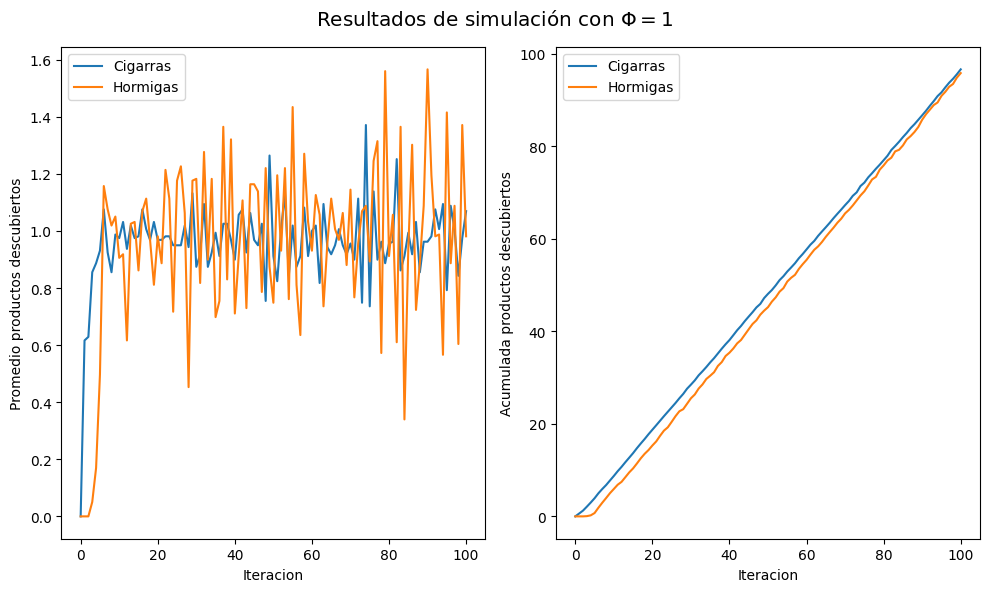

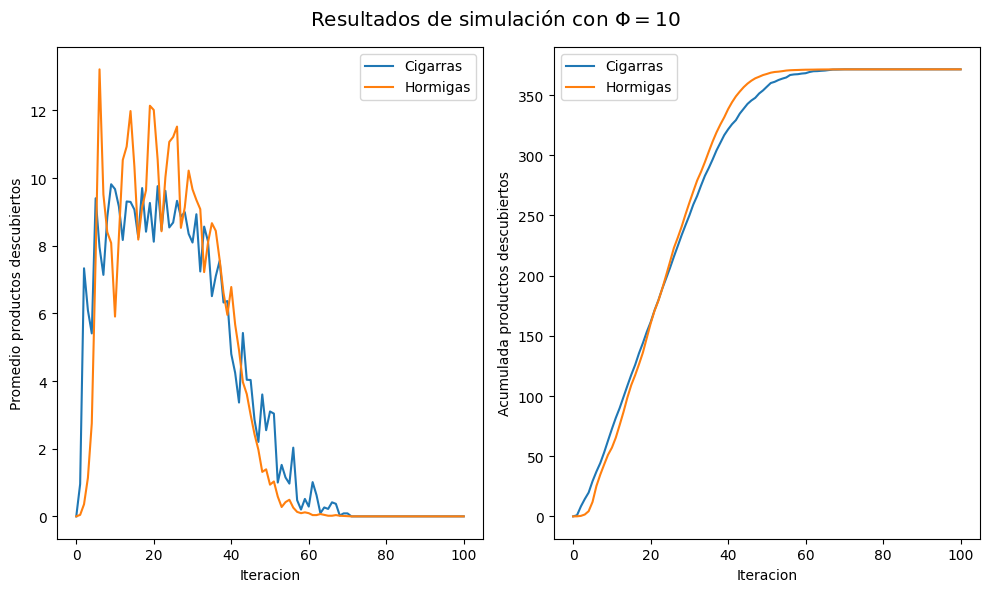

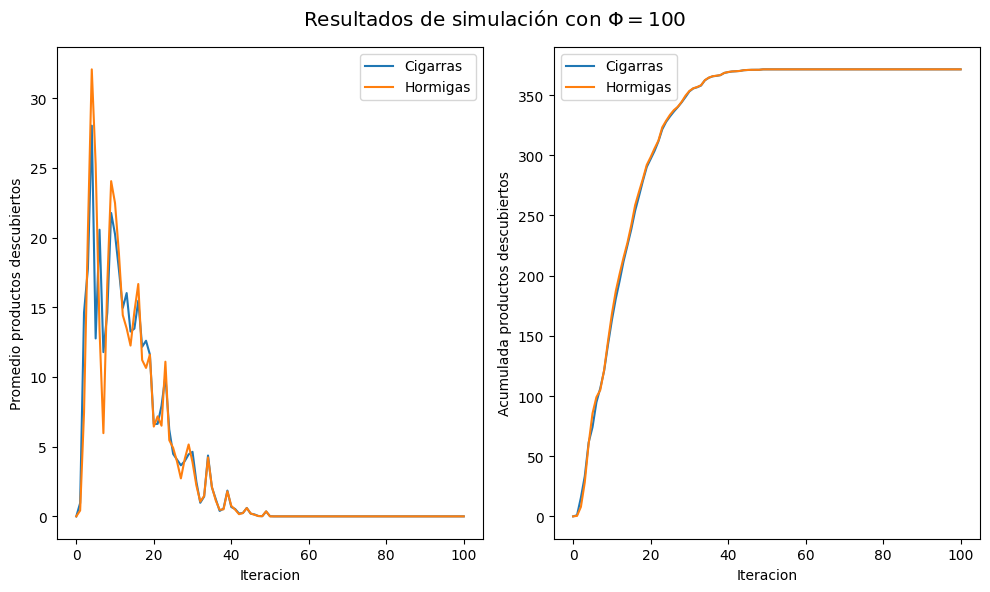

In [7]:
cant_paises = len(M.index.to_list())

for phi, historia_cigarra_fijo, historia_hormiga_fijo in zip(phis, historias_cigarras_fijos, historias_hormigas_fijos):
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(r"Resultados de simulación con $\Phi = %s $" %(str(phi)) , fontsize="x-large")

    plt.subplot(1,2,1)
    plt.plot(range(len(historia_cigarra_fijo)), cantidad_descubrimientos_iteracion(historia_cigarra_fijo) / cant_paises, label='Cigarras')
    plt.plot(range(len(historia_hormiga_fijo)), cantidad_descubrimientos_iteracion(historia_hormiga_fijo) / cant_paises, label='Hormigas')
    plt.xlabel('Iteracion')
    plt.ylabel('Promedio productos descubiertos')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(len(historia_cigarra_fijo)), np.cumsum( cantidad_descubrimientos_iteracion(historia_cigarra_fijo) / cant_paises ) , label='Cigarras')
    plt.plot(range(len(historia_hormiga_fijo)), np.cumsum( cantidad_descubrimientos_iteracion(historia_hormiga_fijo) / cant_paises ) , label='Hormigas')
    plt.xlabel('Iteracion')
    plt.ylabel('Acumulada productos descubiertos')
    plt.legend()

    plt.tight_layout()
    plt.show()